# LPP - Laplacianfaces feature subspace for face recognition

In [515]:
from PIL import Image, ImageEnhance
import numpy as np
import pandas as pd
from PIL import ImageFilter
from matplotlib import pyplot as plt
import colorsys
import cv2
import os
from skimage.filters import gabor, gaussian
from IPython.display import display 
from matplotlib.pyplot import imshow
from pywt import dwt2
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.cluster import KMeans
import random
from sklearn.neighbors import NearestNeighbors

%matplotlib inline

In [516]:
rootLFW="/kaggle/input/lfw-augmented/Augmented_LFW_final/Augmented_LFW_Final/"
rootCD ="/kaggle/input/custom-dataset/Custom_Dataset/"

In [517]:
print(sum([len(os.listdir(rootLFW + x)) for x in os.listdir(rootLFW)]),'images,',
     len(os.listdir(rootLFW)),'people','(LFW)')
print(sum([len(os.listdir(rootCD + x)) for x in os.listdir(rootCD)]),'images,',
     len(os.listdir(rootCD)),'people','(CD)')

3408 images, 50 people (LFW)
2816 images, 39 people (CD)


In [518]:
X = []
Y = []
images = []
for person in os.listdir(rootCD):
    for file in os.listdir(rootCD+person):
        path = rootCD + person + '/' + file
        im = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(32,32))
        X.append(im.flatten())
        images.append(im)
        Y.append(person.replace('_',' '))

X -= np.mean(X, axis=0)
X = np.array(X).T
Y = np.array(Y)

In [519]:
X.shape

(1024, 2816)

In [520]:
def construct_knn_graph(X, k):
    knn = NearestNeighbors(n_neighbors=k + 1)
    knn.fit(X.T)
    _, indices = knn.kneighbors(X.T)
    return indices[:, 1:]

## Similarity graph : between each pair of datapoints

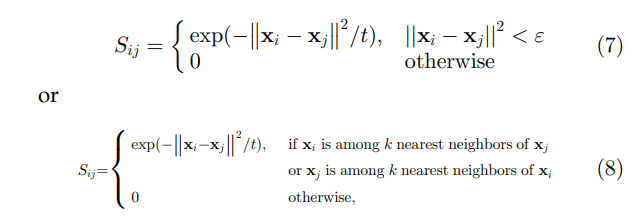

## Cost function :
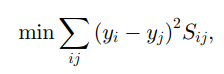

In [521]:
def weightMatrix(X, knn_indices):
    num_samples = X.shape[1]
    W = np.zeros((num_samples, num_samples))
    for i in range(num_samples):
        for j in knn_indices[i]:
            W[i, j] = np.exp(-np.linalg.norm(X[:,i]-X[:,j])/500)
            W[j, i] = W[i,j]
    return W

In [522]:
k = 5
knn_indices = construct_knn_graph(X, k)
S = weightMatrix(X, knn_indices)

## Solution : LPP (approximation)
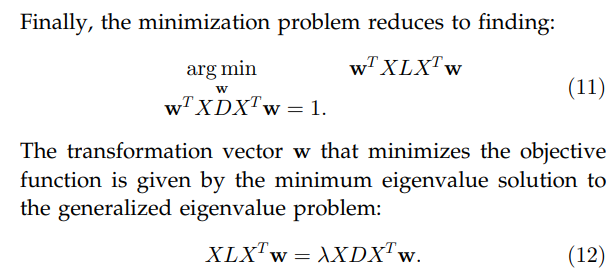

In [523]:
D = np.diag(np.sum(S, axis=1))
L = D - S 

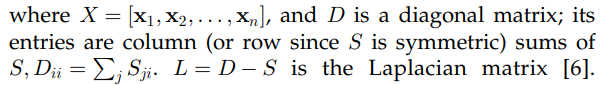

In [524]:
A = X@L@X.T
B = X@D@X.T
C = np.linalg.inv(B)@A

In [525]:
eigenvalues, eigenvectors = np.linalg.eigh(C)

#### Each eigenvector is called a Laplacianface. We take the top 256 Laplacianfaces for subspace projection (Locality preserving projection - LPP)

In [526]:
W = eigenvectors[:,:256]

In [527]:
W.shape

(1024, 256)

In [528]:
Xsub = W.T@X

#### visualising Laplacianfaces

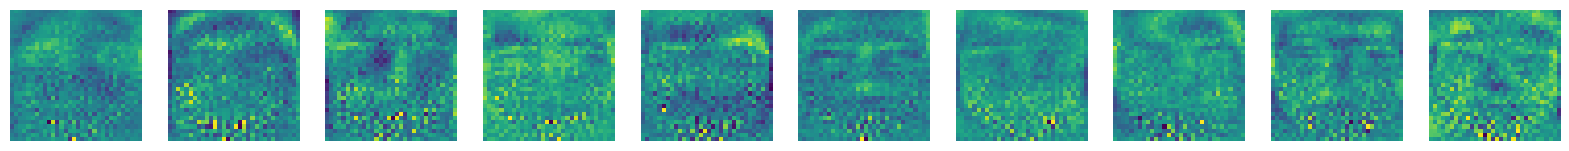

In [529]:
fig, ax = plt.subplots(1,10,figsize=(20,200))
for i in range(10):
    ax[i].imshow(W[:,10+i].reshape((32,32)))
    ax[i].axis('off')

In [530]:
X_train, X_test, Y_train, Y_test = train_test_split(Xsub.T, Y, test_size=0.3,
                                                          random_state=42)

In [531]:
k = 2                                               # Number of neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train, Y_train)
Y_pred = knn_classifier.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred, average='macro')
precision = precision_score(Y_test, Y_pred, average='macro')
recall = recall_score(Y_test, Y_pred, average='macro')

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8899408284023669
F1 Score: 0.8925579772057097
Precision: 0.9050919371803161
Recall: 0.8894413980509321


# Wrapping it all up

In [532]:
def study(X,k):
    knn_indices = construct_knn_graph(X, 5)
    S = weightMatrix(X, knn_indices)
    D = np.diag(np.sum(S, axis=1))
    L = D - S 
    A = X@L@X.T
    B = X@D@X.T
    C = np.linalg.inv(B)@A
    eigenvalues, eigenvectors = np.linalg.eigh(C)
    W = eigenvectors[:,:k]
    Xsub = W.T@X
    X_train, X_test, Y_train, Y_test = train_test_split(Xsub.T, 
                                                Y, test_size=0.3,
                                                random_state=42)
    k = 2                                               # Number of neighbors
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, Y_train)
    Y_pred = knn_classifier.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred, average='macro')
    precision = precision_score(Y_test, Y_pred, average='macro')
    recall = recall_score(Y_test, Y_pred, average='macro')
    
    return accuracy, precision, recall

### 1. LFW

In [533]:
X = []
Y = []
images = []
for person in os.listdir(rootLFW):
    for file in os.listdir(rootLFW+person):
        path = rootLFW + person + '/' + file
        im = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(32,32))
        X.append(im.flatten())
        images.append(im)
        Y.append(person.replace('_',' '))
X -= np.mean(X, axis=0)
X = np.array(X).T
Y = np.array(Y)

In [534]:
study(X,256)

(0.8025415444770283, 0.8219163434937444, 0.8068614639123659)

### 2. Custom dataset

In [535]:
X = []
Y = []
images = []
for person in os.listdir(rootCD):
    for file in os.listdir(rootCD+person):
        path = rootCD + person + '/' + file
        im = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(32,32))
        X.append(im.flatten())
        images.append(im)
        Y.append(person.replace('_',' '))

X -= np.mean(X, axis=0)
X = np.array(X).T
Y = np.array(Y)

In [536]:
study(X,256)

(0.8899408284023669, 0.9050919371803161, 0.8894413980509321)